In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import statsmodels.api as sm
import scipy
import matplotlib as mpl
from amftrack.util.plot import gridplot
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
plt.style.use('presentation.mplstyle')
width = 1.6
height = 1

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure5\PlotsCorentin"
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table = pd.DataFrame()
num_day = 3
for path in paths:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table = pd.concat([table,new])
table["days"] = table["time_since_crossing"] / pd.Timedelta(days=1)
table["3days"] = (table["time_since_crossing"] / pd.Timedelta(days=num_day)).astype(int)
table["days_since_first_image"] = table["days"] - table.groupby("unique_id")[
    "days"
].transform("min")
table["abs_speed-"] = -table["speed-"]

table["speed"] = table[["speed+", "abs_speed-"]].max(1)
grouping = 1
table["lengthdm"] = (np.log2((table["tot_length"]))/grouping).astype(int) * grouping
table["log_tot_num_spores"] = (np.log2((table["tot_num_spore"]))/grouping).astype(int)* grouping
table["log_tot_num_spores"] = (np.log10((table["tot_num_spore"])))

grouping = 1
funtype = 1
time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"

path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['csv_id'] = path
    
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            table_speeds = pd.concat([table_speeds,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))
table_speeds["abs_speed"] = abs(table_speeds['speed']) 
table_speeds = table_speeds.set_index(['csv_id','kymo_id'])
table = table.set_index(['csv_id','kymo_id'])
speedp = table_speeds.loc[table_speeds['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed+'] = mean_speed
speedp = table_speeds.loc[table_speeds['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed-'] = mean_speed
table["mean_speed+"] = table["mean_speed+"].fillna(table["speed+"])
table["mean_speed-"] = table["mean_speed-"].fillna(table["speed-"])
table["ratio"] = -table["mean_speed+"]/table["mean_speed-"]


C:\Users\coren\AppData\Local\Temp\ipykernel_4104\1619894415.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
C:\Users\coren\AppData\Local\Temp\ipykernel_4104\1619894415.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)


In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_bet_2"
paths_bet = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table_bet = pd.DataFrame()
for path in paths_bet:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table_bet = pd.concat([table_bet,new])
table_bet['days'] = table_bet['time_since_crossing']/pd.Timedelta(days=1)
table_bet["days"] = table_bet["time_since_crossing"] / pd.Timedelta(days=1)
table_bet["3days"] = (table_bet["time_since_crossing"] / pd.Timedelta(days=3)).astype(int)
table_bet["days_since_first_image"] = table_bet["days"] - table_bet.groupby("unique_id")[
    "days"
].transform("min")
table_bet["abs_speed-"] = -table_bet["speed-"]

table_bet["speed"] = table_bet[["speed+", "abs_speed-"]].max(1)
# table_bet["lengthdm"] = (np.log2((table_bet["tot_length"])) / 2).astype(int) * 2
# table_bet["log_tot_num_spores"] = (np.log((table_bet["tot_num_spore"]))).astype(int)
path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds_bet = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths_bet):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    table_loc['csv_id'] = path
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            # subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['normalized_random_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['normalized_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['betweenness'] = table_loc['betweenness'].iloc[j]
            subtable['dist_tip'] = table_loc['dist_tip'].iloc[j]
            subtable['num_nodes_tip'] = table_loc['num_nodes_tip'].iloc[j]
            subtable['is_anastomosing'] = table_loc['is_anastomosing'].iloc[j]
            
            
            
            
            subtable['random_betweenness'] = table_loc['random_betweenness'].iloc[j]
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            
            
            
            

            table_speeds_bet = pd.concat([table_speeds_bet,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
# table_speeds_bet["log_tot_num_spores"] = np.log10((table_speeds_bet["tot_num_spore"]))
table_speeds_bet["abs_speed"] = abs(table_speeds_bet['speed']) 
table_speeds_bet = table_speeds_bet.set_index(['csv_id','kymo_id'])
table_bet = table_bet.set_index(['csv_id','kymo_id'])
speedp = table_speeds_bet.loc[table_speeds_bet['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed+'] = mean_speed
speedp = table_speeds_bet.loc[table_speeds_bet['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed-'] = mean_speed
mean_speed = table_speeds_bet.groupby(['csv_id','kymo_id'])['abs_speed'].mean()
table_bet['mean_speed_abs'] = mean_speed
table_bet["mean_speed+"] = table_bet["mean_speed+"].fillna(table_bet["speed+"])
table_bet["mean_speed-"] = table_bet["mean_speed-"].fillna(table_bet["speed-"])
table_bet["mean_speed_abs"] = table_bet["mean_speed_abs"].fillna(table_bet["speed"])
table_bet['days_without'] = table_bet['days']+(table_bet['unique_id']=="799_20211001")*6
table_speeds_bet['days_without'] = table_speeds_bet['days']+(table_speeds_bet['unique_id']=="799_20211001")*6
table_speeds_bet['log_random_betweenness']=np.log(table_speeds_bet['random_betweenness'])
table_speeds_bet['log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness'])
table_speeds_bet['log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness'])
table_speeds_bet = table_speeds_bet.reset_index()
table_bet = table_bet.reset_index()

# table_speeds_bet['int_log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness']).astype(int)
# table_speeds_bet['int_log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness']).astype(int)

C:\Users\coren\AppData\Local\Temp\ipykernel_4104\2218147210.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9


2023-05-10 09:35:14,285-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


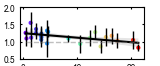

In [4]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
f, ax = plt.subplots(figsize=(width,height/1.5))

cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
select = table.loc[abs(table["ratio"]).between(0,10)]


n_resamples = 1000
selectp = select

mean = selectp.groupby("days_without")["ratio"].median()
std = selectp.groupby("days_without")["ratio"].std()
count = selectp.groupby("days_without")["ratio"].count()
data = np.array((mean.index,mean))
x,y = mean.index,mean
sns.regplot(x = x,
    y = y,ax=ax,scatter=False, color="black")
plt.gca().collections[-1].set_alpha(0.1)
ax.errorbar(mean.index, mean,yerr= 2*std/np.sqrt(count),fmt = 'None',color="black",ecolor="black")
ax.scatter(mean.index, mean,c=mean.index,cmap = "rainbow",s=4)

ax.plot(mean.index, mean*0+1,color="grey",alpha = 0.5,linestyle = '--')

ax.set_ylabel("$v_+/v_-$")
ax.set_ylim(0.5,2)
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*5
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*5

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
select = table_speeds.loc[abs(table_speeds["abs_speed"])>0]
select1 = table_speeds.loc[table_speeds["speed"]>0]
select2 = table_speeds.loc[table_speeds["speed"]<0]
for select in [select1,select2]:

    selectp = select

    mean = selectp.groupby("days_without")["speed"].mean()
    std = selectp.groupby("days_without")["speed"].std()
    count = selectp.groupby("days_without")["speed"].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
ax.set_xlabel("$t_{crossing}$ (days)")




plt.savefig(os.path.join(path_figure,'5C1.pdf'), transparent=True, bbox_inches='tight')

2023-05-10 09:35:16,397-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


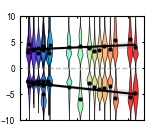

In [5]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
f, ax1 = plt.subplots(figsize=(width,height*1.35))

cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*5
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*5

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
select = table.loc[abs(table["ratio"]).between(0,10)]


n_resamples = 1000
selectp = select

mean = selectp.groupby("days_without")["ratio"].median()
std = selectp.groupby("days_without")["ratio"].std()
count = selectp.groupby("days_without")["ratio"].count()
data = np.array((mean.index,mean))
x,y = mean.index,mean
# sns.regplot(x = x,
#     y = y,ax=ax,scatter=False, color="black")
# ax.scatter(mean.index, mean,c=mean.index,cmap = "rainbow",s=4)
# ax.errorbar(mean.index, mean,yerr= 2*std/np.sqrt(count),fmt = 'None',color="black")
# ax.plot(mean.index, mean*0+1,color="grey",alpha = 0.5,linestyle = '--')

# ax.set_ylabel("ratio")
# ax.set_ylim(0,2)
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
select = table_speeds.loc[abs(table_speeds["abs_speed"])>0]
select1 = table_speeds.loc[table_speeds["speed"]>0]
select2 = table_speeds.loc[table_speeds["speed"]<0]
for select in [select1,select2]:

    selectp = select

    mean = selectp.groupby("days_without")["speed"].mean()
    std = selectp.groupby("days_without")["speed"].std()
    count = selectp.groupby("days_without")["speed"].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax1,scatter=False, color="black")
    plt.gca().collections[-1].set_alpha(0.1)
    
    for tot_num_spores in select["days_without"].unique():
        subselect = select.loc[select["days_without"]==tot_num_spores]
        day = subselect["days_without"].iloc[0]
        parts = ax1.violinplot(subselect["speed"],[day]
                              ,widths = 1,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
            pc.set_alpha(0.8) 
            pc.set_linewidth(0.5)  # Set the width of the edge (line) around the violin body
    ax1.scatter(mean.index, mean,color="black",s=4)

ax1.set_xlabel("days after crossing")

ax1.set_ylabel("$v$ ($\mu m.s^{-1}$)")
ax1.set_xticklabels([])
ax1.set_xlabel('')
plt.savefig(os.path.join(path_figure,'meanspeed_day.png'))
ax1.set_ylim(-10,10)
ax1.hlines(0,0,22,color='grey',linestyle='--',alpha = 0.5)

# plt.savefig(os.path.join(path_figure,'meanspeed_day_uncropped.png'))
# plt.tight_layout()
plt.savefig(os.path.join(path_figure,'5C2.pdf'), bbox_inches='tight',transparent=True)

2023-05-10 09:35:18,495-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


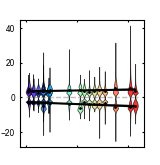

In [6]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (width,1.65*height))
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*5
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*5

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']

select = table_speeds.loc[abs(table_speeds["abs_speed"])>0]

select1 = table_speeds.loc[table_speeds["speed"]>0]
select2 = table_speeds.loc[table_speeds["speed"]<0]
n_resamples = 1000
for select in [select1,select2]:

    selectp = select

    mean = selectp.groupby("days_without")["speed"].mean()
    std = selectp.groupby("days_without")["speed"].std()
    count = selectp.groupby("days_without")["speed"].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax,scatter=False, color="black")
    plt.gca().collections[-1].set_alpha(0.5)
    
    for tot_num_spores in select["days_without"].unique():
        subselect = select.loc[select["days_without"]==tot_num_spores]
        day = subselect["days_without"].iloc[0]
        parts = ax.violinplot(subselect["speed"],[day]
                              ,widths = 1,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
            pc.set_alpha(0.8) 
            pc.set_linewidth(0.5) 
    ax.scatter(mean.index, mean,color="black")
            

ax.set_xlabel("$t_{crossing}")
ax.set_ylabel("$v$ ($\mu m.s^{-1}$)")
ax.set_xticklabels([])
ax.set_xlabel('')
ax.hlines(0,0,22,color='grey',linestyle='--',alpha = 0.5)

# plt.savefig(os.path.join(path_figure,'5B.png'))
plt.savefig(os.path.join(path_figure,'5B.pdf'), bbox_inches='tight',transparent=True)


C:\Users\coren\AppData\Local\Temp\ipykernel_4104\1240502218.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


2023-05-10 09:35:20,578-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


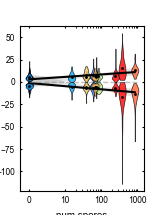

In [7]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (width,height*2.15))
# ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("rainbow")
table["log_tot_num_spores"] = np.log10((table["tot_num_spore"]))

table['log_tot_num_spores_correct'] = (table['log_tot_num_spores']>1)*table['log_tot_num_spores']
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
# select = table_speeds.loc[table_speeds["abs_speed"].between(-50, 50)]
select = table.loc[table["speed"]>0]
select = table


# select = table_speeds.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)

n_resamples = 1000
for column in ['speed+','speed-']:
    select = table.loc[table[column].between(-200,200)]

    selectp = select

    mean = selectp.groupby("log_tot_num_spores_correct")[column].mean()
    std = selectp.groupby("log_tot_num_spores_correct")[column].std()
    count = selectp.groupby("log_tot_num_spores_correct")[column].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax,scatter=False, color="black")
    plt.gca().collections[-1].set_alpha(0.1)
    
    for tot_num_spores in select["log_tot_num_spores"].unique():
        subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
        parts = ax.violinplot(subselect[column],[subselect["log_tot_num_spores_correct"].iloc[0]]
                              ,widths = 0.2,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
            pc.set_alpha(0.8) 
            pc.set_linewidth(0.5) 
    ax.scatter(mean.index, mean,color="black")

ax.set_xlabel("num spores")
ax.set_ylabel("$v_{max}$ ($\mu m.s^{-1}$)")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
labels = [label if label%10==0 or label == 1 else '' for label in labels]
labels = [label if label!=1 else 0 for label in labels]

# ax.set_yscale('symlog')
ax.set_xticklabels(labels)
# ax.set_ylim(-30,30)
# plt.savefig(os.path.join(path_figure,'Figure5D.EPS'))
ax.hlines(0,0,3,color='grey',linestyle='--',alpha = 0.5)
tick_locations = [np.log10(10*i) for i in range(2,10)]
tick_locations += [np.log10(100*i) for i in range(2,10)]


ax.set_xticks(tick_locations,minor=True)
# ax.set_yticks(tick_locations)
plt.savefig(os.path.join(path_figure,'Figure5D.pdf'), bbox_inches='tight',transparent=True)


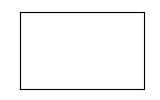

In [8]:
fig, ax = plt.subplots(figsize = (width,height))
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(os.path.join(path_figure,'rectangle.pdf'), bbox_inches='tight',transparent=True)



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
cmap0 = mpl.cm.get_cmap("viridis")


def bootstrap_linear_fit(df, x_col, y_col,group=None, n_bootstraps=1000, plot_bootstraps=False,ax=None,color=None,x_based_color =False,cmap=cmap0):
    
    if group is None:
        # If no grouping is specified, use the entire dataframe
        group_df = df.copy()
    else:
        # Group the dataframe by the specified column and compute the mean of x and y within each group
        group_df = df.groupby(group).mean(numeric_only=True).reset_index()
    
    x = group_df[x_col]
    y = group_df[y_col]

    # Initialize arrays to store bootstrap results
    bootstrap_slopes = np.zeros(n_bootstraps)
    bootstrap_intercepts = np.zeros(n_bootstraps)

    # Perform bootstrap resampling and linear regression n_bootstraps times
    for i in range(n_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        lr = LinearRegression()
        lr.fit(x_bootstrap.values.reshape(-1, 1), y_bootstrap)
        bootstrap_slopes[i] = lr.coef_
        bootstrap_intercepts[i] = lr.intercept_

    # Compute the mean and standard error of the bootstrap slopes and intercepts
    slope_mean = np.mean(bootstrap_slopes)
    slope_se = np.std(bootstrap_slopes, ddof=1)
    intercept_mean = np.mean(bootstrap_intercepts)
    intercept_se = np.std(bootstrap_intercepts, ddof=1)

    # Optionally plot all the bootstrap results lines in light grey
    if plot_bootstraps:
        x_min = x.min()
        x_max = x.max()
        sns.regplot(x = x,
            y = y,ax=ax,scatter=False, color=color)
        # plt.gca().collections[-1].set_alpha(0.5)
        
        if not group is None:
            elements = df[group].unique()
            x_values = df[x_col].unique()
            for element in elements:
                width = (np.max(x_values)-np.min(x_values))/len(x_values)
                subselect = df.loc[df[group]==element]
                xpos = subselect[x_col].iloc[0]
                if x_based_color:
                    scale = np.mean((subselect[x_col]-x_min)/(x_max-x_min))
                    color_violin = cmap(scale)
                else:
                    color_violin = "grey"
                parts = ax.violinplot(subselect[y_col],[xpos]
                                      ,widths = width,showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor(color_violin)
                    pc.set_edgecolor("black")
                    pc.set_alpha(0.8) 
                    pc.set_linewidth(0.5) 
        ax.scatter(x,y,color="black",marker="x")
            
                    
                    # pc.set_edgecolor('black')
        # for i in range(n_bootstraps):
        #     y_bootstrap = bootstrap_intercepts[i] + bootstrap_slopes[i] * x
        #     ax.plot(x, y_bootstrap, color='lightgrey', alpha=0.1)
        # y_mean = intercept_mean + slope_mean * x
        # ax.plot(x, y_mean, color=color, linewidth=2)
        # ax.set_xlim(x_min, x_max)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
    return(slope_mean,slope_se)


In [10]:
csvs = [
    "211012_Plate799.csv",
    "211014_Plate809.csv",
    "201217_Plate09.csv",
    "201217_Plate10.csv",
    "201217_Plate38.csv",
    "211013_Plate809.csv",
    "220324_Plate907.csv" ]

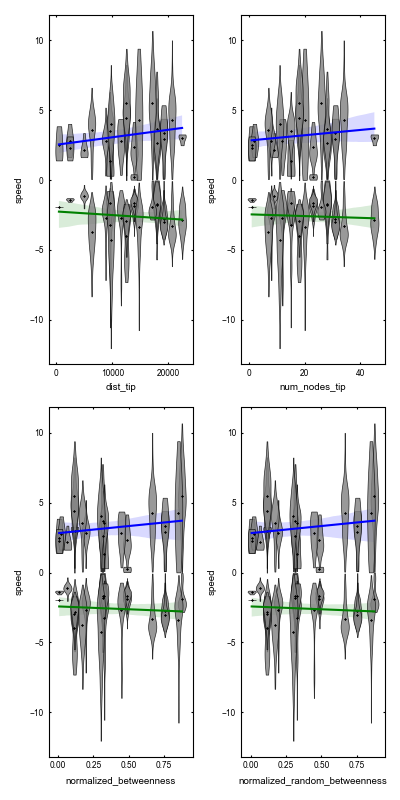

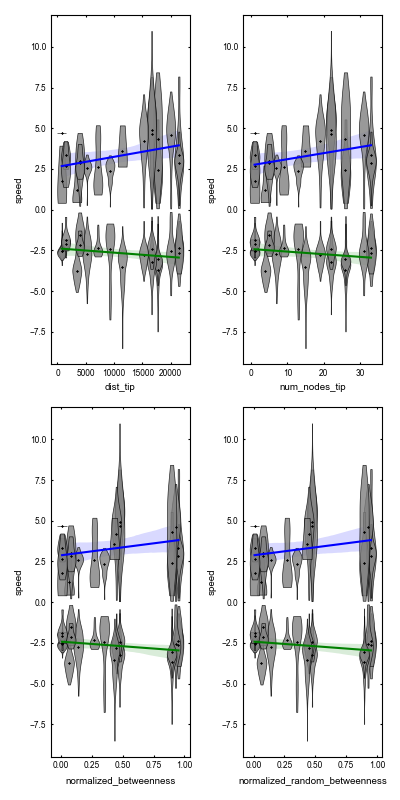

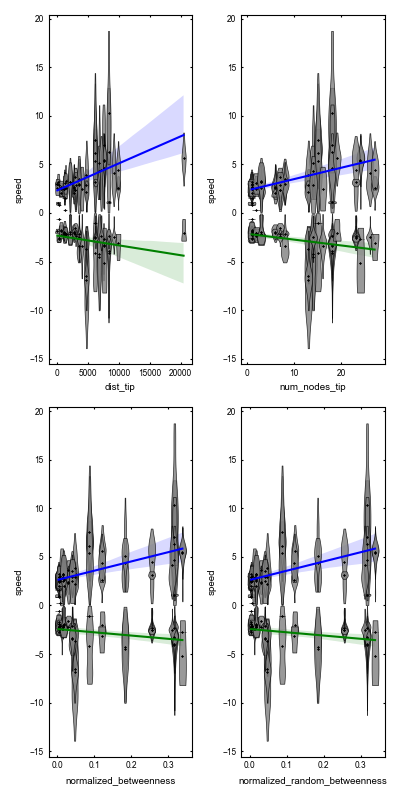

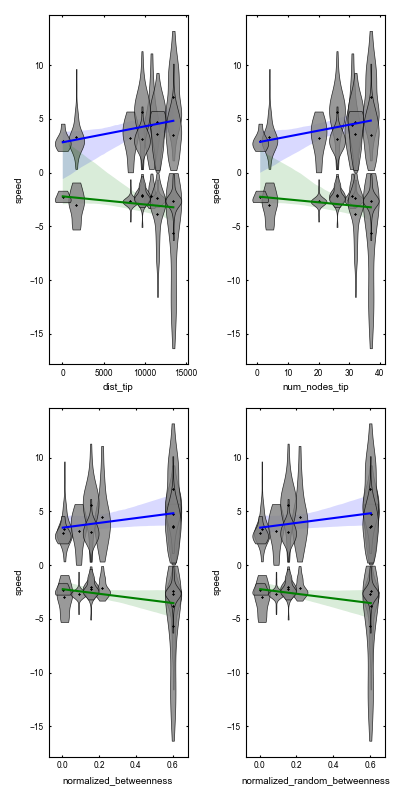

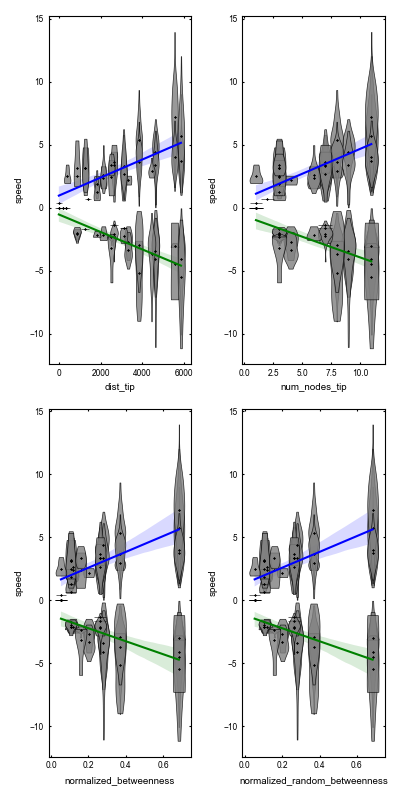

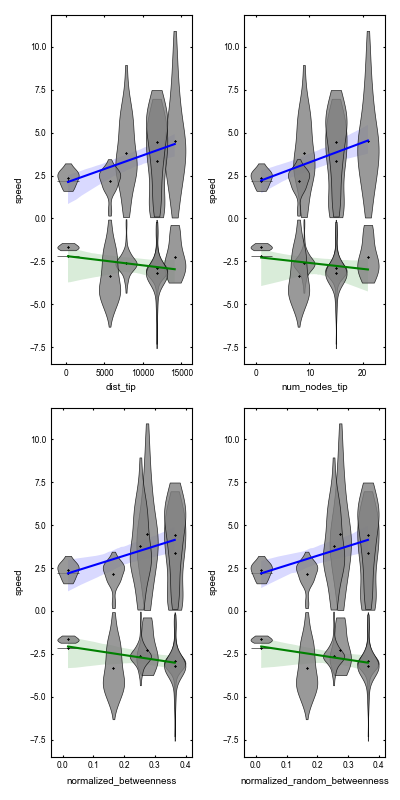

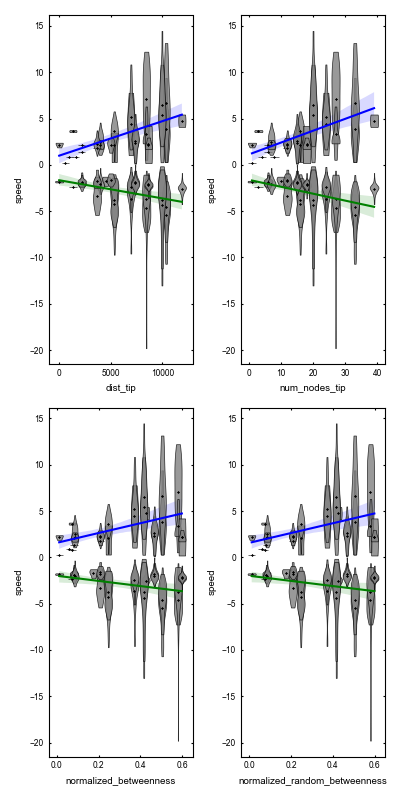

In [11]:
coefs = {}
y_col = "speed"
group = "kymo_id"
x_cols = ["dist_tip","num_nodes_tip","normalized_betweenness","normalized_random_betweenness"]
plot_bootstrap = True
for csv in csvs:
    coefs[csv]={}
    fig,axs = gridplot(len(x_cols),2,subw = 2,subh=4)
    
    for x_col,ax in zip(x_cols,axs):
        # csv = csvs[index]
        high_bet = table_speeds_bet.loc[table_speeds_bet[x_col]>0]
        selection = high_bet.loc[high_bet['csv_id'] == csv]
        selection = selection.loc[selection["is_anastomosing"] == False]      
        select1 = selection.loc[selection["speed"]>=0]
        slope,slope_std = bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=plot_bootstrap,ax=ax,color="blue")
        coefs[csv][f'{x_col}_slope_up'] = slope
        coefs[csv][f'{x_col}_slope_std_up'] = slope_std
        
        
        # bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="purple")
        select1 = selection.loc[selection["speed"]<=0]
        slope,slope_std = bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=plot_bootstrap,ax=ax,color="green")
        coefs[csv][f'{x_col}_slope_down'] = slope
        coefs[csv][f'{x_col}_slope_std_down'] = slope_std        # bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="green")
        # ax.set_ylim(-10,10)
        plt.tight_layout()        
    #     break
    # break


In [14]:
data_slope

,dist_tip_slope_up,dist_tip_slope_std_up,dist_tip_slope_down,dist_tip_slope_std_down,num_nodes_tip_slope_up,num_nodes_tip_slope_std_up,num_nodes_tip_slope_down,num_nodes_tip_slope_std_down,normalized_betweenness_slope_up,normalized_betweenness_slope_std_up,normalized_betweenness_slope_down,normalized_betweenness_slope_std_down,normalized_random_betweenness_slope_up,normalized_random_betweenness_slope_std_up,normalized_random_betweenness_slope_down,normalized_random_betweenness_slope_std_down
211012_Plate799.csv,0.000054,0.000027,-0.000024,0.000034,0.020155,0.014460,-0.001921,0.022359,0.828948,0.968726,-0.354592,0.634201,0.927845,0.955875,-0.496703,0.658008
211014_Plate809.csv,0.000064,0.000034,-0.000029,0.000016,0.039015,0.019755,-0.016647,0.011679,1.034456,0.677536,-0.595466,0.374541,1.025229,0.580358,-0.526429,0.293079
201217_Plate09.csv,0.000284,0.000077,-0.000118,0.000072,0.121735,0.028139,-0.059419,0.014339,9.785724,2.356840,-3.289082,1.142728,9.480362,2.386379,-3.294240,1.087086
201217_Plate10.csv,0.000107,0.000055,-0.000232,0.000056,0.053362,0.020041,-0.077360,0.023353,3.380894,0.937317,-0.514395,1.338638,3.443201,0.897303,-0.519198,1.239029
201217_Plate38.csv,0.000578,0.000154,-0.000641,0.000097,0.299264,0.094946,-0.290925,0.053953,6.677262,1.589306,-5.089772,1.147745,6.754821,1.523149,-5.139276,1.063781
211013_Plate809.csv,0.000166,0.000037,-0.000050,0.000063,0.114023,0.023030,-0.041415,0.041322,5.836212,1.826810,-2.214859,2.279888,5.587474,1.714473,-2.598803,1.399625
220324_Plate907.csv,0.000324,0.000069,-0.000181,0.000042,0.112802,0.027605,-0.072139,0.019095,4.680878,1.431060,-2.471460,0.770012,4.703205,1.671297,-2.577527,0.857394


2023-05-10 09:38:34,064-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


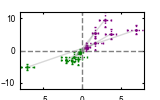

In [15]:
import matplotlib.ticker as ticker
symbols = ['o', 's', '*', 'D', 'X', 'P', 'v']
data_slope = pd.DataFrame.from_dict(coefs).transpose()
x_col1 = "dist_tip"
x_col2 = "normalized_betweenness"
fig,ax = plt.subplots(figsize = (width,height))

direction = "up"
x1,y1 = data_slope[f'{x_col1}_slope_{direction}'],data_slope[f'{x_col2}_slope_{direction}']
x_error,y_error = data_slope[f'{x_col1}_slope_std_{direction}'],data_slope[f'{x_col2}_slope_std_{direction}']
eb1 = ax.errorbar(x1, y1, xerr=x_error, yerr=y_error,
                  fmt='o',elinewidth = 1,capsize=1, capthick=1,ecolor="purple",color="purple")
eb1[-1][0].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorba,r lines
eb1[-1][1].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorbar lines

direction = "down"
x2,y2 = data_slope[f'{x_col1}_slope_{direction}'],data_slope[f'{x_col2}_slope_{direction}']
x_error,y_error = data_slope[f'{x_col1}_slope_std_{direction}'],data_slope[f'{x_col2}_slope_std_{direction}']

eb1 = ax.errorbar(x2, y2, xerr=x_error, yerr=y_error,
                  fmt='o',elinewidth = 1,capsize=1, capthick=1,ecolor="green",color="green")
eb1[-1][0].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorba,r lines
eb1[-1][1].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorbar lines

for i in range(len(x1)):
    ax.plot((x1[i],x2[i]),(y1[i],y2[i]),color="grey",alpha = 0.3)
ax.set_xlim(-8e-4,8e-4)
ax.set_ylim(-12,12)
ax.vlines(0,-12,12,color="grey",linestyle ="--")
# ax.hlines(0,-8e-4,8e-4,color="grey",linestyle ="--")
ax.axhline(y=0, color="grey", linestyle="--")  # add a horizontal line at y=0
ax.set_xlabel(r"$\Delta v/\Delta d_{tip}$ ($s^{-1}$)")
ax.set_ylabel(r"$\Delta v/\Delta BC$ ($\mu m. s^{-1}$)")
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
# ax.xaxis.offsetText.set_visible(False)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'5F.png'))
plt.savefig(os.path.join(path_figure,'5F.pdf'), bbox_inches='tight',transparent=True)

NameError: name 'table_length' is not defined

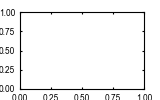

In [13]:
import matplotlib.ticker as ticker
symbols = ['o', 's', '*', 'D', 'X', 'P', 'v']
data_slope = pd.DataFrame.from_dict(coefs).transpose()
x_col1 = "dist_tip"
x_col2 = "normalized_betweenness"
x_G = "days_without"
fig,ax = plt.subplots(figsize = (width,height))

direction = "up"
x1,y1,csvs = data_slope[f'{x_col1}_slope_{direction}'],data_slope[f'{x_col2}_slope_{direction}'],data_slope.index
x_error1,y_error1 = data_slope[f'{x_col1}_slope_std_{direction}'],data_slope[f'{x_col2}_slope_std_{direction}']

direction = "down"
x2,y2 = data_slope[f'{x_col1}_slope_{direction}'],data_slope[f'{x_col2}_slope_{direction}']
x_error2,y_error2 = data_slope[f'{x_col1}_slope_std_{direction}'],data_slope[f'{x_col2}_slope_std_{direction}']
lengths = []
for i in range(len(x1)):
    length= table_length.loc[table_length['csv_id']== csvs[i]][x_G].unique()[0]
    ax.errorbar(length,x1[i],yerr = x_error1[i],color="purple",marker = "v",markersize = 2,ecolor="black")
    lengths.append(length)
sorted_list = sorted(zip(lengths,x1))  
sort_lengths = [c[0] for c in sorted_list]
x1 = [c[1] for c in sorted_list]

ax.plot(sort_lengths,x1, color='red')
for i in range(len(x1)):
    length= table_length.loc[table_length['csv_id']== csvs[i]][x_G].unique()[0]
    ax.errorbar(length,x2[i],yerr = x_error2[i],color="green",marker = "v",markersize = 2,ecolor="black")

sorted_list = sorted(zip(lengths,x2))  
sort_lengths = [c[0] for c in sorted_list]
x2 = [c[1] for c in sorted_list]

ax.plot(sort_lengths,x2, color='red')
ax2 = ax.twinx()
for i in range(len(x1)):
    length= table_length.loc[table_length['csv_id']== csvs[i]][x_G].unique()[0]
    ax2.errorbar(length,y1[i],yerr = y_error1[i],color="purple",marker = "D",markersize = 2,ecolor="black")
sorted_list = sorted(zip(lengths,y1))  
sort_lengths = [c[0] for c in sorted_list]
y1 = [c[1] for c in sorted_list]

ax2.plot(sort_lengths,y1, color='blue')
for i in range(len(x1)):
    length= table_length.loc[table_length['csv_id']== csvs[i]][x_G].unique()[0]
    ax2.errorbar(length,y2[i],yerr = y_error2[i],color="green",marker = "D",markersize = 2,ecolor="black")

sorted_list = sorted(zip(lengths,y2))  
sort_lengths = [c[0] for c in sorted_list]
y2 = [c[1] for c in sorted_list]

ax2.plot(sort_lengths,y2, color='blue')
# ax.set_xscale("log")
ax.set_ylim(-10e-4,10e-4)
ax2.set_ylim(-12,12)
ax.axhline(y=0, color="grey", linestyle="--")  # add a horizontal line at y=0
ax.set_ylabel(r"$\Delta v/\Delta d_{tip}$ ($s^{-1}$)",labelpad = 1,color="blue")
ax2.set_ylabel(r"$\Delta v/\Delta BC$ ($\mu m. s^{-1}$)",labelpad = 1,color = "red")
# ax.set_xlabel(r"network length ($\mu m$)")
ax.set_xlabel(r"$t_{crossing}$ (days)")

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig(os.path.join(path_figure,'5F3.pdf'), bbox_inches='tight',transparent=True)

In [149]:
table_length

,csv_id,kymo_id,Unnamed: 0,video_id,posx,posy,speed+,speed-,spore_density_1,spore_density_1000,...,days_since_first_image,abs_speed-,speed,lengthdm,log_tot_num_spores,mean_speed+,mean_speed-,ratio,days_without,log_tot_num_spores_correct
0,201209_Plate40.csv,1,0,1,4851,566,7.0437,-14.6430,0.0,0.001728,...,0.0,14.6430,14.6430,21,2.579784,7.043700,-8.474338,0.831180,20.393056,2.579784
1,201209_Plate40.csv,2,1,1,4851,566,24.0480,-46.8660,0.0,0.001728,...,0.0,46.8660,46.8660,21,2.579784,9.418463,-5.616957,1.676791,20.393056,2.579784
2,201209_Plate40.csv,3,2,1,4851,566,11.5420,-113.8200,0.0,0.001728,...,0.0,113.8200,113.8200,21,2.579784,6.416638,-2.821900,2.273871,20.393056,2.579784
3,201209_Plate40.csv,4,3,2,4750,872,17.2230,-46.4940,0.0,0.000000,...,0.0,46.4940,46.4940,21,2.579784,8.943775,-46.494000,0.192364,20.393056,2.579784
4,201209_Plate40.csv,5,4,2,4750,872,19.5500,-19.7400,0.0,0.000000,...,0.0,19.7400,19.7400,21,2.579784,5.625500,-7.769419,0.724057,20.393056,2.579784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,220324_Plate907.csv,54,53,31,6076,4316,4.2120,-2.8493,0.0,0.000000,...,0.0,2.8493,4.2120,17,1.176091,2.840514,-2.151692,1.320131,4.599306,1.176091
1236,220324_Plate907.csv,55,54,31,6076,4316,2.4984,-2.3206,0.0,0.000000,...,0.0,2.3206,2.4984,17,1.176091,2.318650,-1.967409,1.178530,4.599306,1.176091
1237,220324_Plate907.csv,56,55,32,5953,4303,3.4437,-2.5234,0.0,0.000000,...,0.0,2.5234,3.4437,17,1.176091,2.744525,-1.846965,1.485965,4.599306,1.176091
1238,220324_Plate907.csv,57,56,33,5844,4294,1.3163,-2.2406,0.0,0.000000,...,0.0,2.2406,2.2406,17,1.176091,1.316300,-1.817300,0.724316,4.599306,1.176091


In [62]:
table_length.loc[table_length['csv_id']== "211012_Plate799.csv"]['tot_length'].unique()[0]

1063503.6654097636

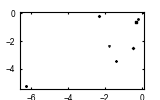

In [19]:
fig,ax = plt.subplots(figsize = (width,height))

for i in range(len(x)):
    ax.scatter(x[i],y[i],marker = symbols[i],color="black")
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


In [19]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

2023-05-08 21:46:30,495-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


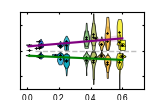

In [20]:
high_bet = table_speeds_bet.loc[table_speeds_bet['normalized_betweenness']>0]
high_bet = high_bet.loc[high_bet['is_anastomosing']==False]

selection = high_bet.loc[high_bet['csv_id'] == '220324_Plate907.csv']
# selection = high_bet
colors = ['#4B378D','#F8E500']

# create the colormap
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)
cmap = parula_map
select1 = selection.loc[selection["speed"]>=0]
x_col = "normalized_betweenness"
y_col = "speed"
group = "kymo_id"
x_based_color = True
fig,ax = plt.subplots(figsize = (width,height))
bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="purple",
                     x_based_color=x_based_color,cmap=cmap)
select1 = selection.loc[selection["speed"]<=0]

bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="green",
                     x_based_color=x_based_color,cmap=cmap)
ax.set_ylim(-15,15)
ax.hlines(0,0.05,0.7,color='grey',linestyle='--',alpha = 0.5)
ax.set_xlabel("betweenness centrality (BC)")
# ax.set_ylabel("$v$ ($\mu m.s^{-1}$)")
ax.set_yticklabels([])
ax.set_ylabel('')
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'5E_inset.png'))
plt.savefig(os.path.join(path_figure,'5E.pdf'), bbox_inches='tight',transparent=True)


2023-05-08 21:46:32,995-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


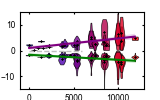

In [21]:
high_bet = table_speeds_bet.loc[table_speeds_bet['normalized_betweenness']>0]
high_bet = high_bet.loc[high_bet['is_anastomosing']==False]

selection = high_bet.loc[high_bet['csv_id'] == '220324_Plate907.csv']
# selection = high_bet
colors = ['#0000FF','#FF0000']

# create the colormap
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)

select1 = selection.loc[selection["speed"]>=0]
x_col = "dist_tip"
y_col = "speed"
group = "kymo_id"
x_based_color = True
fig,ax = plt.subplots(figsize = (width,height))
bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="purple",
                     x_based_color=x_based_color,cmap=cmap)
select1 = selection.loc[selection["speed"]<=0]

bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="green",
                     x_based_color=x_based_color,cmap=cmap)
ax.set_ylim(-15,15)
ax.set_xlabel("$d_{tip}$ ($\mu m$)")
ax.set_ylabel("$v$ ($\mu m.s^{-1}$)")
ax.hlines(0,0,6000,color='grey',linestyle='--',alpha = 0.5)
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'5E.png'))
# plt.savefig(os.path.join(path_figure,'5E.EPS'))
plt.savefig(os.path.join(path_figure,'5G.pdf'), bbox_inches='tight',transparent=True)



In [ ]:
def plot_shade(df,xcolumn,ycolumn,color,ax):
    meancurve = df.groupby(xcolumn)[ycolumn].mean()
    stdcurve = df.groupby(xcolumn)[ycolumn].std()
    countcurve = df.groupby(xcolumn)[ycolumn].count()
    err = 2*stdcurve/np.sqrt(countcurve)
    ax.plot(meancurve.index,meancurve,color=color,linewidth = 1)
    ax.fill_between(meancurve.index, meancurve-err, meancurve+err,color=color,alpha = 0.4)
    return(meancurve)

In [113]:
list(table_group.columns)

['num_trunks',
 'area',
 'area_sep_comp',
 'num_tips',
 'num_nodes',
 'area_study',
 'num_tips_study',
 'num_nodes_study',
 'num_edges_study',
 'tot_length',
 'tot_length_study',
 'out_study',
 'mean_straightness',
 'spore_volume',
 'num_spores',
 'tot_biovolume_study',
 'tot_biovolume',
 'date',
 'Plate',
 'path_exp',
 'folder_analysis',
 'ring_biovolume_density_incr-100_index-0',
 'ring_biovolume_density_incr-100_index-1',
 'ring_biovolume_density_incr-100_index-2',
 'ring_biovolume_density_incr-100_index-3',
 'ring_biovolume_density_incr-100_index-4',
 'ring_biovolume_density_incr-100_index-5',
 'ring_biovolume_density_incr-100_index-6',
 'ring_biovolume_density_incr-100_index-7',
 'ring_biovolume_density_incr-100_index-8',
 'ring_biovolume_density_incr-100_index-9',
 'ring_biovolume_density_incr-100_index-10',
 'ring_biovolume_density_incr-100_index-11',
 'ring_biovolume_density_incr-100_index-12',
 'ring_biovolume_density_incr-100_index-13',
 'ring_biovolume_density_incr-100_index

2023-04-28 15:00:59,868-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


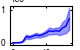

In [158]:
fig,ax = plt.subplots(figsize = (width/2,height/2))
y = "spore_volume"

for unique_id in time_plate_info['unique_id'].unique():
    select = time_plate_info.loc[time_plate_info['time_since_begin_h']<450]
    # select = time_plate_info.loc[time_plate_info['time_since_begin_h']<900]
    
    select = select.loc[select['unique_id']==unique_id]
    select = select.loc[select[y]>0]
    select = select.sort_values('time_since_begin_h')
    # if len(select)>0:
    #     ax.plot(select["time_since_begin_h"]/24,select[y]-select[y].iloc[0],label=unique_id,alpha = 0.2)

mini = time_plate_info.groupby('unique_id')[y].min()
maxi = time_plate_info.groupby('unique_id')[y].max()

table_group = time_plate_info.set_index('unique_id').copy()
table_group['mini']= mini
table_group['spore_reduced'] = table_group[y]-table_group['mini']
table_group['maxi']= maxi
table_group = table_group.loc[table_group['maxi']>0]
table_group = table_group.loc[table_group['day']<18]
data = table_group.groupby('day')["spore_reduced"].median()
data = table_group.groupby('day')["spore_reduced"].std()
data = table_group.groupby('day')["spore_reduced"].count()


data = data.loc[data.index<17]

plot_shade(table_group,'day','spore_reduced',"blue",ax)
# ax.set_yscale('log')
# ax.legend()
ax.set_xlabel('$t_{crossing}$ (days)',labelpad = 1)
ax.set_ylabel('$\Omega_{spore}$ ($\mu m^{3}$)', labelpad=1)
# plt.tight_layout()
plt.savefig(os.path.join(path_figure,'spores.pdf'), bbox_inches='tight',transparent=True)


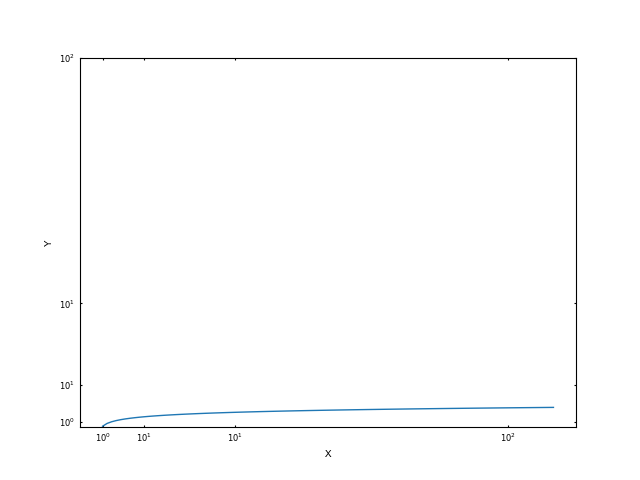

In [126]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
fig,ax = plt.subplots()

# Generate some data
x = np.linspace(1, 100, 100)
y = np.log(x)

# Plot the data
plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')

# Define the log tick format function
def log_tick_formatter(x, pos):
    """
    Custom tick formatter for logarithmic ticks
    """
    # Get the logarithm of the tick value
    logx = np.log10(x)
    # Format the tick label as a LaTeX string with superscript
    return fr'$10^{{{logx:.0f}}}$'

# Set the tick formatter for both x-axis and y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

# Show the plot
tick_locations = [1, 10, 30, 90]

# Set the tick locations on the x-axis and y-axis
plt.gca().set_xticks(tick_locations)
plt.gca().set_yticks(tick_locations)
plt.show()


In [94]:
corr = table_bet[x_cols+["mean_speed+","mean_speed-"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,dist_tip,num_nodes_tip,normalized_betweenness,normalized_random_betweenness,mean_speed+,mean_speed-
dist_tip,1.000000,0.872720,0.733617,0.704978,0.354098,-0.361864
num_nodes_tip,0.872720,1.000000,0.595905,0.633150,0.403387,-0.438870
normalized_betweenness,0.733617,0.595905,1.000000,0.838742,0.321477,-0.284760
normalized_random_betweenness,0.704978,0.633150,0.838742,1.000000,0.378183,-0.251129
mean_speed+,0.354098,0.403387,0.321477,0.378183,1.000000,-0.535884
mean_speed-,-0.361864,-0.438870,-0.284760,-0.251129,-0.535884,1.000000
